## Libraries

In [2]:
import os
import numpy as np
import cv2 # OpenCV-Python
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.cluster import KMeans
import sys
from Functions.object_detection import *
import colorsys
%matplotlib inline

In [3]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data/"
querys_path = "../../Circuito_Almeria_171021/Iniciados/Examples/"

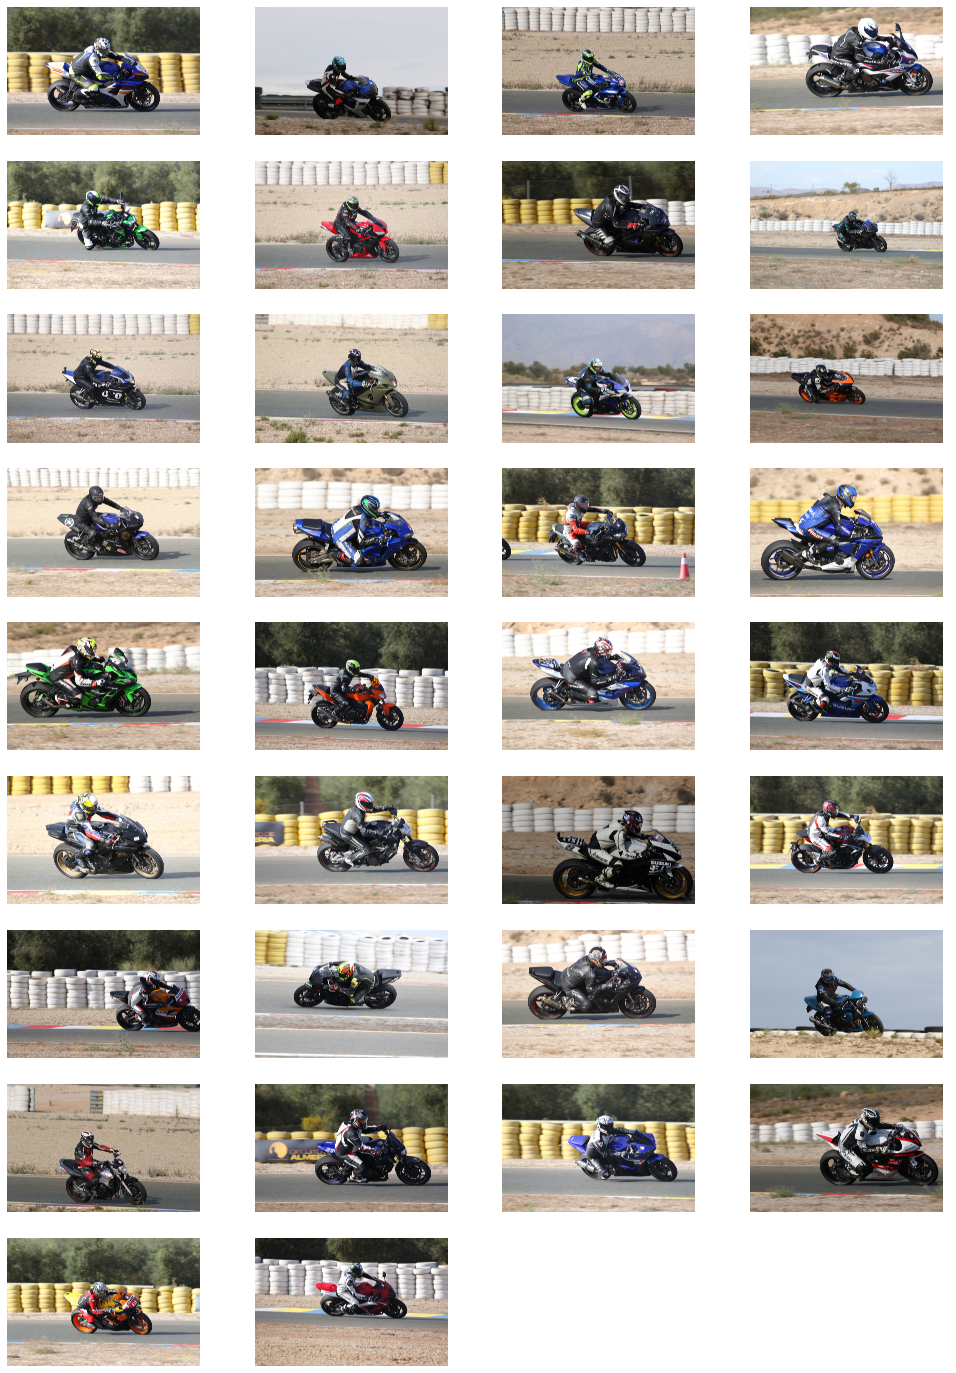

In [4]:
moto_querys = []
folder_names_list = []
fig, axs = plt.subplots(9, 4, figsize = (17,25))
for i, moto in enumerate(os.listdir((querys_path))):
    folder_names_list.append(moto[:-4])
    moto_query = cv2.imread(os.path.join(querys_path, moto))
    moto_querys.append(moto_query)
    axs[i//4][i%4].imshow(cv2.cvtColor(moto_query, cv2.COLOR_BGR2RGB))
for i in range(9*4):
    axs[i//4][i%4].axis("off")
pos2nb_dict = dict(zip(np.arange(len(folder_names_list)), folder_names_list))

### Resizing

In [5]:
scales = [100, 50, 33, 25, 10, 5]

In [6]:
motos_querys = {}
for scale in scales:
    motos_querys[scale] = {}
for i, moto_query in enumerate(moto_querys):
    for scale in scales:
        # THE NEW DIMENSIONS ARE COMPUTED
        width = int(moto_query.shape[1] * scale / 100)
        height = int(moto_query.shape[0] * scale / 100)
        dim = (width, height)
        # Resizing the image
        resized = cv2.resize(moto_query, dim, interpolation = cv2.INTER_AREA)
        motos_querys[scale][i] = resized
del moto_query

In [178]:
scale=25

In [179]:
left_r = 0
right_r = 0.201097
top_r = 0.384615
bottom_r = 0.659340

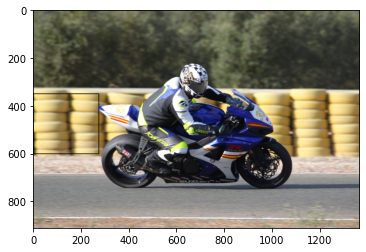

In [180]:
img = motos_querys[scale][0].copy()
height, width, three = img.shape
left = int(left_r*width)
right = int(right_r*width)
top = int(top_r*height)
bottom = int(bottom_r*height)
cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0,0,0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

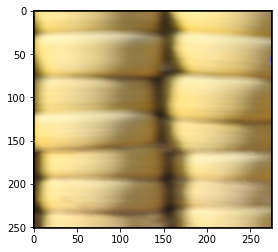

In [181]:
plt.imshow(cv2.cvtColor(img[top:bottom,left:right,:], cv2.COLOR_BGR2RGB))
plt.show()

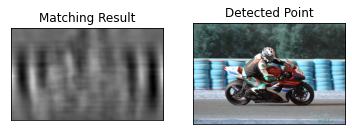

In [182]:
w = right-left
h = bottom-top
img = motos_querys[scale][0].copy()
res = cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),cv2.cvtColor(img[top:bottom,left:right,:], cv2.COLOR_BGR2GRAY), cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()

In [183]:
thr = 20000000

In [184]:
w

275

In [185]:
h

251

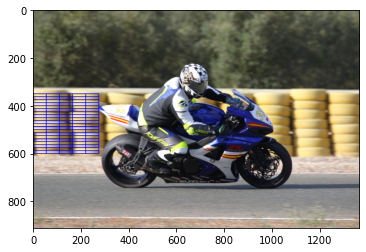

In [266]:
count = 0
n_win_hor = 5
n_win_ver = 20
img_clean = motos_querys[scale][0].copy()
img = motos_querys[scale][0].copy()
img_background_wires = img[top:bottom,left:right,:]
# Iterate through width (half window size step)
for i in range(n_win_ver-1):
    top_w = int(top+i*h/n_win_ver)
    bottom_w = int(top_w+h/(n_win_ver/2))
    # Iterate through width (half window size step)
    for j in range(n_win_hor-1):
        left_w = int(left+j*w/n_win_hor)
        right_w = int(left_w+w/(n_win_hor/2))
        cv2.rectangle(img,(left_w, top_w), (right_w, bottom_w), 255, 2)
        window = img_clean[top_w:bottom_w, left_w:right_w,:]
        count += 1
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [209]:
count

76

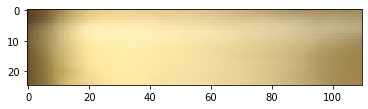

In [267]:
plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
plt.show()

In [262]:
window.shape

(25, 110, 3)

In [263]:
win_size = (16, 16)
cell_size = (8, 8)
block_size = (16, 16)
block_stride = (4, 4)
n_bins_orientation = 9
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,n_bins_orientation)

In [264]:
hog.compute(cv2.cvtColor(window, cv2.COLOR_BGR2GRAY))

array([2.67790437e-01, 3.03190589e-01, 3.03190589e-01, 3.06478571e-02,
       8.68114457e-03, 0.00000000e+00, 0.00000000e+00, 1.26125058e-03,
       9.54014063e-02, 3.03190589e-01, 1.22180074e-01, 9.09915641e-02,
       4.67726775e-03, 4.99159796e-03, 0.00000000e+00, 0.00000000e+00,
       8.05295557e-02, 3.03190589e-01, 3.03190589e-01, 3.03190589e-01,
       3.03190589e-01, 1.96790751e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.40257946e-03, 1.23125747e-01, 3.03190589e-01,
       1.56557009e-01, 8.15318599e-02, 2.52746884e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.06297426e-01, 3.03190589e-01,
       2.50247955e-01, 2.99871176e-01, 2.99871176e-01, 1.17060617e-01,
       0.00000000e+00, 0.00000000e+00, 2.65199837e-04, 3.30576897e-02,
       1.36699468e-01, 2.89423198e-01, 1.48017153e-01, 1.05915517e-01,
       1.76108163e-02, 0.00000000e+00, 0.00000000e+00, 3.23634641e-03,
       2.99871176e-01, 2.99871176e-01, 9.25064608e-02, 1.66368306e-01,
      

In [251]:
thr = 35000000

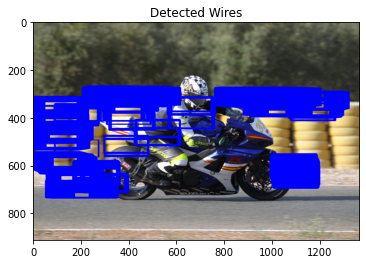

In [203]:
n_win_hor = 3
n_win_ver = 7
img = motos_querys[scale][0].copy()
img_background_wires = img[top:bottom,left:right,:]
# Iterate through width (half window size step)
for i in range(n_win_ver-1):
    top_w = int(top+i*h/n_win_ver)
    bottom_w = int(top_w+h/(n_win_ver/2))
    # Iterate through width (half window size step)
    for j in range(n_win_hor-1):
        left_w = int(left+j*w/n_win_hor)
        right_w = int(left_w+w/(n_win_hor/2))
        window = img[top_w:bottom_w, left_w:right_w,:]
        res = cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),cv2.cvtColor(window, cv2.COLOR_BGR2GRAY), cv2.TM_CCOEFF)
        for top_left in np.argwhere(res>thr):
            top_left = top_left[::-1]
            bottom_right = (top_left[0] + right_w - left_w, top_left[1] + bottom_w - top_w)
            cv2.rectangle(img,top_left, bottom_right, 255, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Wires')
plt.show()

In [145]:
top_w

139

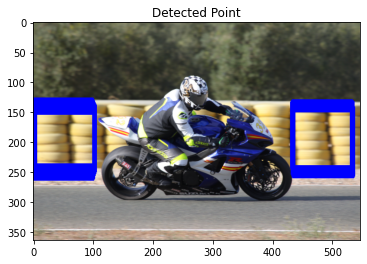

In [137]:
img = motos_querys[scale][0].copy()
for top_left in np.argwhere(res>thr):
    top_left = top_left[::-1]
    bottom_right = (top_left[0] + h, top_left[1] + w)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Point')
plt.show()

(array([ 2745.,  8589., 15054., 56732., 42844., 11714.,  5997.,  3291.,
         1447.,   427.]),
 array([-7806132. , -5861176. , -3916219.5, -1971263.4,   -26307.2,
         1918649. ,  3863605.2,  5808561.5,  7753517.5,  9698474. ,
        11643430. ], dtype=float32),
 <BarContainer object of 10 artists>)

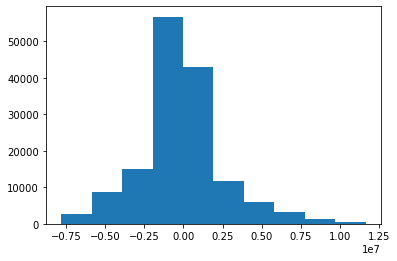

In [100]:
plt.hist(res.flatten())

In [26]:
from scipy import signal
cor = signal.correlate2d (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img[top:bottom,left:right,:], cv2.COLOR_BGR2GRAY))

In [36]:
from numpy import unravel_index
unravel_index(np.argmax(cor), cor.shape)

(0, 24)

In [29]:
cor.shape

(463, 656)

(array([2305., 1147., 1159., 1209., 1186., 1171., 1238., 1202., 1168.,
        1178., 1158., 1190., 1147., 1172., 1196., 1229., 1180., 1144.,
        1219., 1243., 1166., 1157., 1152., 1182., 1173., 1182., 1195.,
        1148., 1165., 1206., 1182., 1140., 1150., 1167., 1155., 1188.,
        1169., 1206., 1180., 1114., 1187., 1175., 1245., 1174., 1182.,
        1215., 1220., 1207., 1196., 1224., 1174., 1189., 1198., 1165.,
        1139., 1222., 1192., 1197., 1218., 1134., 1166., 1139., 1128.,
        1211., 1161., 1194., 1161., 1297., 1144., 1183., 1122., 1124.,
        1188., 1208., 1186., 1139., 1245., 1192., 1180., 1200., 1229.,
        1199., 1231., 1194., 1210., 1179., 1132., 1219., 1111., 1119.,
        1248., 1166., 1224., 1156., 1195., 1203., 1197., 1269., 1180.,
        1156., 1191., 1123., 1144., 1149., 1196., 1163., 1199., 1196.,
        1257., 1178., 1224., 1161., 1200., 1224., 1157., 1139., 1204.,
        1164., 1167., 1189., 1156., 1191., 1175., 1202., 1101., 1176.,
      

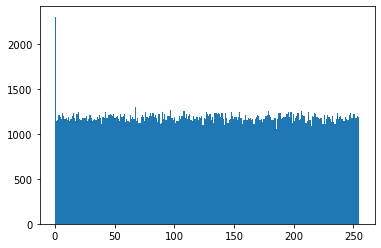

In [46]:
plt.hist(cor.flatten(), bins=256)

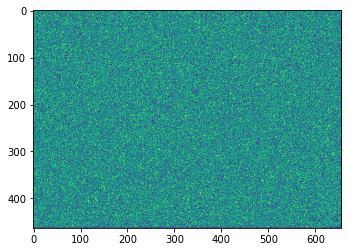

In [23]:
plt.imshow(cor)

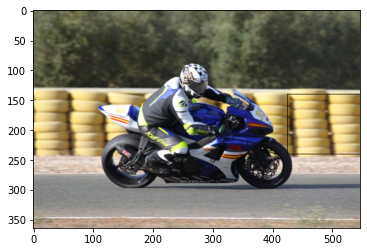

In [12]:
img = motos_querys[scale][0].copy()
height, width, three = img.shape
left = 425
right = width
top = 140
bottom = 240
cv2.line(img, (int(left), int(top)), (int(left), int(bottom)), (0,0,0))
cv2.line(img, (int(left), int(top)), (int(right), int(top)), (0,0,0))
cv2.line(img, (int(right), int(top)), (int(right), int(bottom)), (0,0,0))
cv2.line(img, (int(right), int(bottom)), (int(left), int(bottom)), (0,0,0))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
width

547